In [5]:
! py -m pip install --upgrade pip
! pip install wheel setuptools pip --upgrade
! pip install swig
! pip install gymnasium[box2d]
! pip install moviepy
! pip install numpy
! pip install -U matplotlib

     ---------------------------------------- 0.0/162.6 kB ? eta -:--:--
     ------------------------------------- 162.6/162.6 kB 10.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   --- ------------------------------------ 0.7/7.6 MB 20.8 MB/s eta 0:00:01
   ------- -------------------------------- 1.4/7.6 MB 14.5 MB/s eta 0:00:01
   ------------- -------------------------- 2.6/7.6 MB 18.2 MB/s eta 0:00:01
   -------------- ------------------------- 2.7/7.6 MB 15.9 MB/s eta 0:00:01
   -------------- ------------------------- 2.9/7.6 MB 13.1 MB/s eta 0:00:01
   --------------- ------------------------ 3.0/7.6 MB 11.3 MB/s eta 0:00:01
   ---------------- ----------------------- 3.1/7.6 MB 9.9 MB/s eta 0:00:01
   ---------------- ----------------------- 3.2/7.6 MB 9.3 MB/s eta 0:00:01
   ----------------- ---------------------- 3.3/7.6 MB 8.0 MB/s eta 0:00:01
   ----------------- ---------------------- 3.3/7.6 MB 7.6 MB/s eta 0:00:01
   ---------

# Remarks

If the video does not work, it is advisable to restart the entire kernel after the initial installation.

In [6]:
import gymnasium
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder

env = gymnasium.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5,
    render_mode = "rgb_array"
)

observation, info = env.reset()
videoPath = "video.mp4"
video = VideoRecorder(env, videoPath)

for _ in range(200):
    env.render()
    video.capture_frame()
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    print(observation, reward, terminated, truncated, info)

video.close()
env.close()

[ 0.00535965  1.3985415   0.27724606 -0.2676438  -0.00531928 -0.04602603
  0.          0.        ] 0.2303596828672994 False False {}
[ 0.0081089   1.3919191   0.27725312 -0.29433706 -0.00761912 -0.04600114
  0.          0.        ] -1.469157581438651 False False {}
[ 0.01078529  1.3846952   0.26811248 -0.32106486 -0.00808425 -0.00930357
  0.          0.        ] -0.7494307532862468 False False {}
[ 0.01332998  1.3778809   0.25560245 -0.30285957 -0.00920672 -0.02245159
  0.          0.        ] 2.4656227508770714 False False {}
[ 0.01593475  1.3704715   0.2631488  -0.3293323  -0.0118397  -0.05266476
  0.          0.        ] -2.080122602163128 False False {}
[ 0.01846581  1.3624736   0.25387597 -0.3554643  -0.01260878 -0.01538287
  0.          0.        ] -0.8366187327633259 False False {}
[ 0.02105894  1.3538839   0.2616777  -0.38179663 -0.01494094 -0.0466475
  0.          0.        ] -2.0130263320860124 False False {}
[ 0.02365217  1.3446939   0.2616854  -0.40846542 -0.01727166 -0.046

Moviepy - Done !
Moviepy - video ready video.mp4


# Training the Lunar Lander

In [171]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import itertools

In [187]:
env = gym.make(
        "LunarLander-v2",
        continuous = False,
        gravity = -10.0,
        enable_wind = False,
        wind_power = 15.0,
        turbulence_power = 1.5,
        render_mode = "rgb_array"
)

# Lower and higher limits of observation space
observationSpaceLow = (-1.5, -1.5, -5., -5., -3.1415927, -5., -0., -0.)
observationSpaceHigh = (1.5, 1.5, 5., 5., 3.1415927, 5., 1., 1.)
observationSpace = list(zip(observationSpaceLow,observationSpaceHigh))

# Create bins/intervals for observations
def makeIntervals(observationSpace, intervals=10):
    observationsInterval = []
    
    for observation in observationSpace[:-2]:
        observationInterval = []
        stepSize = (observation[1] - observation[0]) / intervals
        
        for step in np.arange(observation[0], observation[1]+stepSize, stepSize):
            observationInterval.append(step)
        
        observationsInterval.append(observationInterval)
        
    for _ in range(2):
        observationsInterval.append([0., 1.])
    
    return observationsInterval

def makeQTable(observationsInterval, n_action):
    QTable = {}
    permutations = list(itertools.product(*observationsInterval))
    for permutation in permutations:
        QTable[permutation] = [0.] * n_action

    return QTable

# Check state
def checkInterval(observations, observationsInterval, observationSpace):
    observationsKey = ()

    # For each observation
    for index, observation in enumerate(observations[:6]):
        
        # Process Angle
        if index == 4 or index == 5:
            observation = observation % 3.1415927,

        # Clip Limits
        clipObservation = np.clip(observation, observationSpace[index][0], observationSpace[index][1])
        
        for lower, upper in zip(observationsInterval[index][:-1], observationsInterval[index][1:]):
            if lower <= clipObservation < upper or clipObservation == upper:
                observationsKey += (lower,)
                break

    left, right = observations[-2:]
    observationsKey += (left, right,)

    return observationsKey

In [196]:
observationsInterval =  makeIntervals(observationSpace, intervals=5)
QTable = makeQTable(observationsInterval, env.action_space.n)
len(QTable)

186624

Text(0, 0.5, 'EPS')

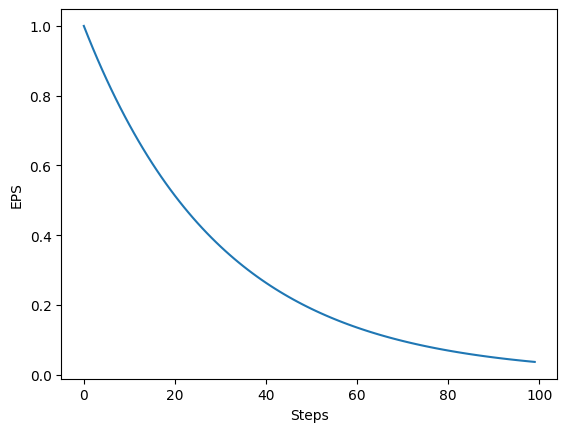

In [197]:
def greedyEPS(epsStart, epsEnd, epsDecay, step):
    return epsEnd + (epsStart - epsEnd) * np.exp(-1 * step / epsDecay)

# Example of EPS
epsStart = 1.0
epsEnd = 0.0
epsDecay = 30
step = np.arange(0, 100, 1)
eps = greedyEPS(epsStart, epsEnd, epsDecay, step)

plt.plot(step, eps)
plt.xlabel("Steps")
plt.ylabel("EPS")

In [198]:
epsStart = 1.0
epsEnd = 0.0
epsDecay = 30
learningRate = 0.1
discountedEstimate = 0.95
episodes = 100000
maxSteps = 100

for episode in range(episodes):
    print("Starting Episode: ", episode)
    currentObservations, _ = env.reset()

    for step in range(maxSteps):
        eps = greedyEPS(epsStart, epsEnd, epsDecay, episode)
        action = env.action_space.sample() if np.random.random() < eps else np.argmax(QTable[checkInterval(currentObservations, observationsInterval, observationSpace)])
        newObservations, reward, termination, truncation, info = env.step(action)
        currentObservationsKey = checkInterval(currentObservations, observationsInterval, observationSpace)
        newObservationsKey = checkInterval(newObservations, observationsInterval, observationSpace)
        QTable[currentObservationsKey][action] = QTable[currentObservationsKey][action] + learningRate * (reward + 0.95 * np.max(QTable[newObservationsKey]) - QTable[currentObservationsKey][action])

        if termination or truncation:
            break

        currentObservations = newObservations    

Starting Episode:  0
Starting Episode:  1
Starting Episode:  2
Starting Episode:  3
Starting Episode:  4
Starting Episode:  5
Starting Episode:  6
Starting Episode:  7
Starting Episode:  8
Starting Episode:  9
Starting Episode:  10
Starting Episode:  11
Starting Episode:  12
Starting Episode:  13
Starting Episode:  14
Starting Episode:  15
Starting Episode:  16
Starting Episode:  17
Starting Episode:  18
Starting Episode:  19
Starting Episode:  20
Starting Episode:  21
Starting Episode:  22
Starting Episode:  23
Starting Episode:  24
Starting Episode:  25
Starting Episode:  26
Starting Episode:  27
Starting Episode:  28
Starting Episode:  29
Starting Episode:  30
Starting Episode:  31
Starting Episode:  32
Starting Episode:  33
Starting Episode:  34
Starting Episode:  35
Starting Episode:  36
Starting Episode:  37
Starting Episode:  38
Starting Episode:  39
Starting Episode:  40
Starting Episode:  41
Starting Episode:  42
Starting Episode:  43
Starting Episode:  44
Starting Episode:  4

KeyboardInterrupt: 

In [194]:
import gymnasium
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder

env = gymnasium.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5,
    render_mode = "rgb_array"
)

observation, info = env.reset()
videoPath = "video.mp4"
video = VideoRecorder(env, videoPath)

for step in range(200):
    env.render()
    video.capture_frame()
    action = np.argmax(QTable[checkInterval(currentObservations, observationsInterval, observationSpace)])
    newObservation, reward, termination, truncation, info = env.step(action)
    
    if termination or truncation:
        break

    observation = newObservation

video.close()
env.close()

Moviepy - Building video video.mp4.
Moviepy - Writing video video.mp4



Moviepy - Done !
Moviepy - video ready video.mp4


In [182]:
len(QTable)

186624